In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import display

# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

In [2]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))

Shape of data frame: (48026, 49)
Keys of enquiries_dataset: 
Index(['Tracking ID', 'Marketing Code', 'Original Code', 'Marketing Name',
       'Classification', 'App Source', 'Web Source', 'Enquired', 'First Call',
       'Last Access', 'Last Access By', 'Next Contact Date', 'Decision',
       'Appointed', 'Submitted', 'Lead Approval Date',
       'Reporting Approval Date', 'Potential Settlement Date', 'Settled',
       'Lender', 'HLC', 'Rejected Reason', 'Loan Amount', 'Enquiry Status',
       'Hot Transfer', 'Held', 'Held By', 'Processing System', 'Lead Status',
       'Client Name', 'Suburb', 'State', 'Post Code', 'Area eChoice Direct',
       'Email', 'Mobile', 'Phone', 'Home Phone', 'Dead Reason', 'Broker Name',
       'Capacity Area', 'Lead Source', 'Commission In', 'Commission Out',
       'Lead Assist', 'loan_reason', 'property_use', 'consumer_comment',
       'internal_comment'],
      dtype='object')


In [3]:
pre_drop_features = ['Tracking ID','Original Code','Marketing Name', 'Next Contact Date', 
                     'Appointed', 'First Call','Last Access', 'Last Access By', 'Next Contact Date', 
                     'Decision','Lender','Rejected Reason','Hot Transfer','Held', 'Held By', 
                     'Processing System', 'Lead Status','Mobile', 'Phone', 'Home Phone', 
                     'Dead Reason', 'Broker Name','consumer_comment','internal_comment']
df = df.drop(pre_drop_features, 1)

In [4]:
# Filter more
pre_drop_features = ['Lead Approval Date','Reporting Approval Date', 
                     'Potential Settlement Date', 'Settled','Capacity Area','Lead Source', 
                     'Commission In', 'Commission Out','Lead Assist','Area eChoice Direct']
df = df.drop(pre_drop_features, 1)

In [5]:
# Filter more
pre_drop_features = ['HLC','Submitted','Client Name']
df = df.drop(pre_drop_features, 1)

In [6]:
print("Shape of data frame: {}".format(df.shape))

Shape of data frame: (48026, 13)


In [7]:
# drop any nan column
df = df.dropna(axis=0, how='any')
print("Shape of data frame: {}".format(df.shape))

Shape of data frame: (33805, 13)


In [8]:
print("List of data types: \n{}".format(df.dtypes))

List of data types: 
Marketing Code     object
Classification     object
App Source         object
Web Source         object
Enquired           object
Loan Amount        object
Enquiry Status     object
Suburb             object
State              object
Post Code         float64
Email              object
loan_reason        object
property_use       object
dtype: object


In [9]:
df['Post Code'] = df['Post Code'].astype(int)
df.fillna(0)
print("List of data types: \n{}".format(df.dtypes))

List of data types: 
Marketing Code    object
Classification    object
App Source        object
Web Source        object
Enquired          object
Loan Amount       object
Enquiry Status    object
Suburb            object
State             object
Post Code          int64
Email             object
loan_reason       object
property_use      object
dtype: object


In [10]:
X = df.loc[:, df.columns != 'Enquiry Status']
y = df['Enquiry Status']

In [11]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline

# pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
# pipe_lr.fit(X_train, y_train)
# y_pred = pipe_lr.predict(X_test)
# print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [18]:
from sklearn.preprocessing import LabelEncoder
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

le = LabelEncoder()
# Categorial feature ecoding
X = MultiColumnLabelEncoder(columns = X.keys()).fit_transform(X)
y = le.fit_transform(y)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

(33805, 12)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Test Accuracy: 0.777


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500,random_state=1)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))

scores = cross_val_score(rfc, X_test_scaled, y_test)
print("Cross-validation scores: {}".format(scores.mean()))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Test score: 0.84


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Cross-validation scores: 0.8141264708252741


 1) Enquired                       0.153587
 2) Loan Amount                    0.152707
 3) Email                          0.145262
 4) Suburb                         0.142453
 5) Post Code                      0.135908
 6) Marketing Code                 0.091100
 7) loan_reason                    0.071808
 8) Classification                 0.040969
 9) App Source                     0.040115
10) State                          0.025987
11) Web Source                     0.000104


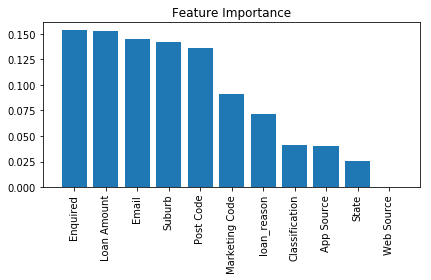

In [16]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [17]:
input_x = df.iloc[:]
input_x_test = df.iloc[:,idxs_selected]

input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
input_x_test = scaler.fit_transform(input_x_test)

result = rfc.predict(input_x_test)
result = le.inverse_transform(result)
proba = rfc.predict_proba(input_x_test)   
proba = [np.max(p) for p in proba]

NameError: name 'df_enquiries' is not defined